# Explore data
To see how we can use our data, we do some investigation.

In [2]:
# Load libraries
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import linear_model
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from yellowbrick.regressor import ResidualsPlot, PredictionError

C:\Users\Rinze\.conda\envs\matrix\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [44]:
# Load pickle file
df = pd.read_pickle("../data/intermediate.pkl")

In [47]:
[col for col in df.columns if col.startswith("vve")]

['vve_contribution',
 'vve_kvk',
 'vve_am',
 'vve_per_contr',
 'vve_reserve_fund',
 'vve_maintenance',
 'vve_insurance']

In [36]:
# Temp solution
df.rename(columns={"rf_plat dak": "rf_plat_dak", 
                   "address_x": "address"}, 
          inplace=True)

In [18]:
# Use a subset without neighborhoods for correlation check
subset = df[[col for col in df.columns if not col.startswith("ne")]]

## Correlation check
Initially we want to know what factors have a big influence on the asking price.

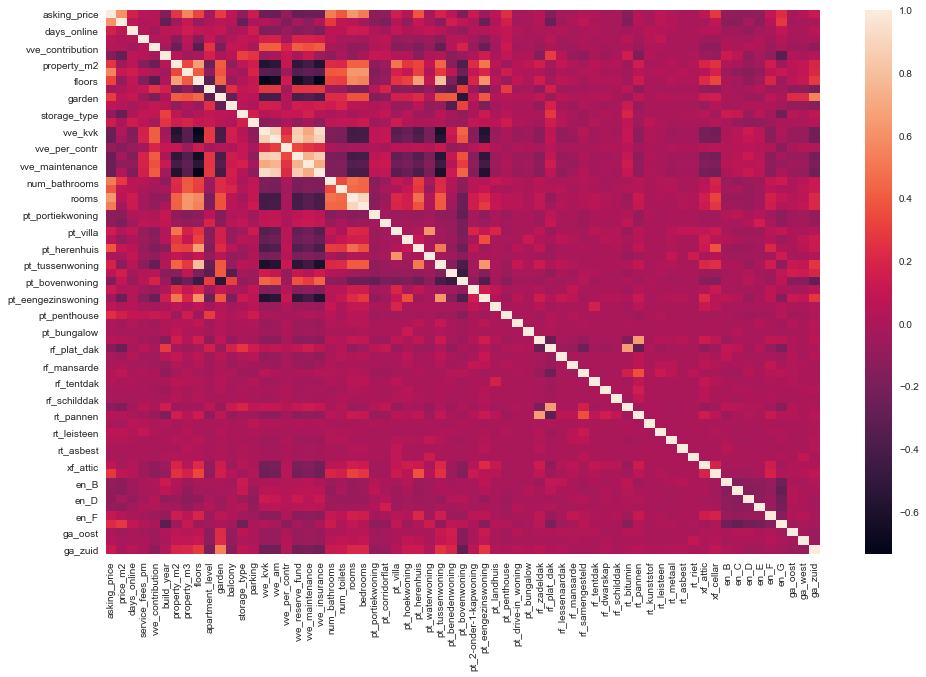

In [133]:
# Produce a heatmap 
fig, ax = plt.subplots(figsize=(16,10))
sns.heatmap(subset.corr())

There seems to be high correlation between the various VVE columns, so we decide to drop all but 1.

The same applies to for 2 roof types and forms. 

In [37]:
# Drop columns
vve = [col 
       for col in df.columns 
       if col.startswith("vve") 
       and col not in ["vve_contribution", "vve_maintenance"]]
others = ["rt_pannen", "rf_plat_dak", "address", "price_m2"]

df.drop(columns=vve + others, inplace=True)

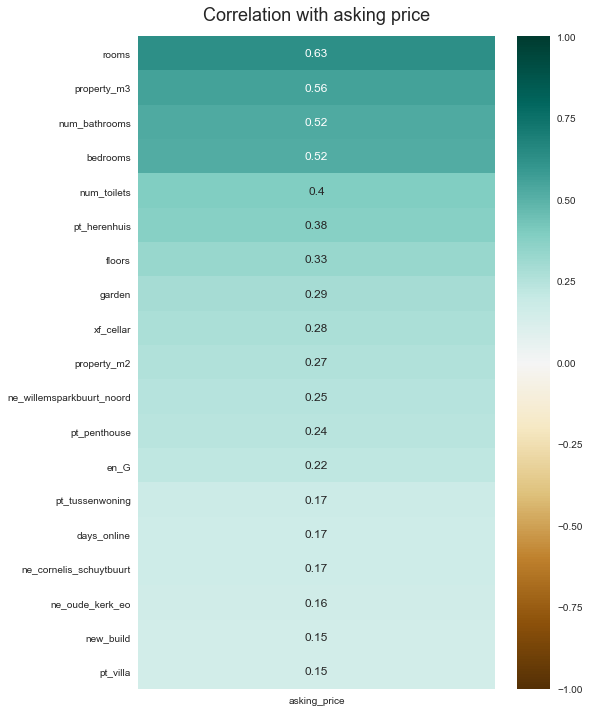

In [7]:
# Correlation viewed related to asking price
corr_series = df.corr()[["asking_price"]].sort_values(by="asking_price", ascending=False)

plt.figure(figsize=(8, 12))
heatmap = sns.heatmap(corr_series[1:20], 
                      vmin=-1, 
                      vmax=1, 
                      annot=True, 
                      cmap='BrBG')
heatmap.set_title("Correlation with asking price", 
                  fontdict={'fontsize':18}, 
                  pad=16);

## Preprocessing

In [38]:
# Select column names of factors with more than 2 values
num_cols = [col for col in df.columns 
            if df[col].nunique() > 2 
            and df[col].dtype in ["int64", "float64"] 
            and col != "asking_price"]

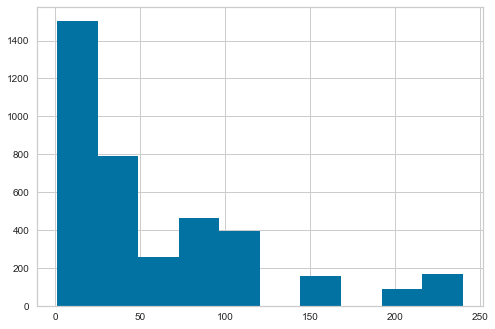

In [9]:
df["days_online"].hist();

In [39]:
df.reset_index(drop=True, inplace=True)

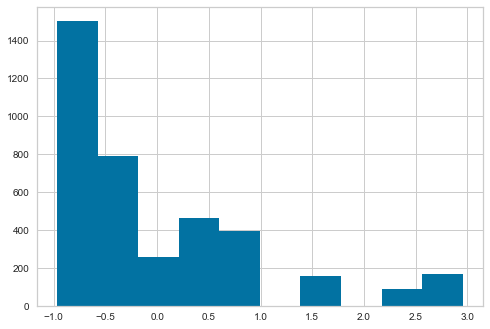

In [40]:
# Fit scaler model and apply to dataframe
std = StandardScaler()
scaled_fit = std.fit(df[num_cols])
df[num_cols] = pd.DataFrame(scaled_fit.transform(df[num_cols]), columns=num_cols)
df["days_online"].hist()

## Split data

In [41]:
# Set variables
X = df[[col for col in df.columns if col != "asking_price"]]
y = df["asking_price"]

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.4, random_state=7)

## Linear regression
Now we train a model to check for linear regression.

In [43]:
# Instantiate the class
lin_model = linear_model.LinearRegression()
# Create the model
lin_model.fit(X_train, y_train)
score = lin_model.score(X_train, y_train)
print(f"R2: {score:.3f}")

R2: 0.800


Our initial score is not very high. This could have various reasons. Most obvious is the way we selected our features. 

In [104]:
def visualize_model(plot, model, train, test):
    visualizer = plot(model)
    visualizer.fit(*train)
    visualizer.score(*test)
    visualizer.show() 

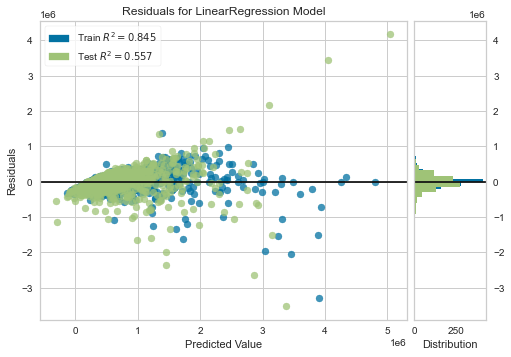

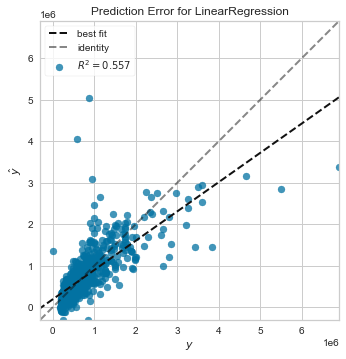

In [154]:
#fig, axes = plt.subplots(2, 1, figsize=(16,10))
for i, plot in enumerate([ResidualsPlot, PredictionError]):
    visualize_model(plot, lin_model, (X_train, y_train), (X_test, y_test))

#### Interpretation
The points are notrandomly dispersed around the horizontal axis,  which means that a linear regression model is probably not appropriate for the data and we should use a non-linear model. The R<sup>2</sup> for the training set is very good, however the R<sup>2</sup> for the test set is average, which also shows in the fact that the train data (green) is normally distributed around 0, but not the test data.

## Try different models